# Farnebäck

In this notebook, we're going to test out the Farnebäck method with different parameters and on different images to try and find the best parameters for this method.

The Farnebäck method uses polynomial expansion to model the local image intensities and their changes between two frames. It approximates each pixel neighborhood with a quadratic polynomial and calculates the displacement vectors by comparing these models across consecutive frames.

## Importing necessary libraries and notebooks

In [1]:
import xarray as xr
import io
import os
import cv2
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker
from IPython.display import Image, display
from PIL import Image as PILImage


# Append the parent directory (Sargassum) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# Import the other notebooks without running their cells
from ii_Data_Manipulation import visualize_4
from iii_GOES_average import time_list, visualize_aggregate, calculate_median
from iv_Image_Processing import collect_times, crop_image, save_aggregate, binarize_image, bilateral_image, process_dates, process_directory
from v_i_OF_Functions import *

## Farneback_flow

In [2]:
def farneback(prev_img, next_img, flow = None, pyr_scale=0.5, levels=3, winsize=15, 
        iterations=3, poly_n=5, poly_sigma=1.2, flags=0):
    """
    Returns:
    - flow : np.ndarray
        The computed flow image that will have the same size as `prev_img` and
        type CV_32FC2. Each element of the flow matrix will be a vector that
        indicates the displacement (in pixels) of the corresponding pixel from
        the first image to the second image.

    Method Parameters:
    - flow : np.ndarray
        Optional input flow estimate. It must be a single precision floating point
        image with the same size as `prev_img`. If provided, the function uses it as
        an initial approximation of the flow. If None, the function estimates the flow
        from scratch.
    - pyr_scale : float
        The image scale (<1) to build pyramids for each image; pyr_scale=0.5
        means a classical pyramid, where each next layer is twice smaller than
        the previous one.
    - levels : int
        The number of pyramid layers including the initial image. Levels=1
        means that no extra layers are created and only the original images are used.
    - winsize : int
        The size of the window used to smooth derivatives used as a basis
        for the polynomial expansion. The larger the size, the smoother the
        input image and the more robust the algorithm is to noise, but the more
        blurred motion details become.
    - iterations : int
        The number of iterations the algorithm will perform at each pyramid level.
        More iterations can improve the accuracy of the flow estimation.
    - poly_n : int
        The size of the pixel neighborhood used to find polynomial expansion
        in each pixel. Typical values are 5 or 7.
    - poly_sigma : float
        The standard deviation of the Gaussian that is used to smooth derivatives
        used as a basis for the polynomial expansion. This parameter can
        typically be ~1.1 for poly_n=5 and ~1.5 for poly_n=7.
    - flags : int
        Operation flags that can specify extra options such as using the initial
        flow estimates or applying a more sophisticated form of smoothing:
        - cv2.OPTFLOW_USE_INITIAL_FLOW: Uses the input flow as an initial flow estimate.
        - cv2.OPTFLOW_FARNEBACK_GAUSSIAN: Uses a Gaussian window for smoothing
          derivatives instead of a box filter.
    """
    # Make images grayscale
    prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        prev_img, next_img, flow = flow, pyr_scale=pyr_scale, levels=levels, winsize=winsize, 
        iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma, flags=flags
    )
    return flow

In [ ]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)
    #display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png", width =750))

In [ ]:
if __name__ == '__main__':
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback_flow(prev_img, next_img)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)
    #display(Image(filename="/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png", width =750))

## Changing Parameters

### pyr_scale
The image scale (<1) to build pyramids for each image; pyr_scale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one.

For large displacements, smaller values should be better.

In [ ]:
if __name__ == '__main__':
    pyr_scale=0.1
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

Fixing **pyr_scale=0.1** does seem to give the best results (especially in the Binarized image) where the motion vectors for the left aggregation seem to be more correct. Going lower than 0.1 can inverse the direction of vectors.

### levels
The number of pyramid layers including the initial image. Levels=1 means that no extra layers are created and only the original images are used.

For large displacements, bigger values should be better.

In [ ]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

For **pyr_scale=0.1** changing the number of levels doesn't seem to have an impact.

### winsize
Averaging window size; larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field.

For large displacements, bigger values should be better. 

In [ ]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

Bigger values make the motion vectors more uniform, the default value **winsize=15** makes sense for now.

### iterations
Number of iterations the algorithm does at each pyramid level. 

In [ ]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    iterations=4
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

Having more iterations tends to increase the "vorticity" of the algae. Having more iterations does not necessarily mean better results as a very high number of iterations (1000) can break the algorithm. For now we'll go with **iterations=4**.

### poly_n
Size of the pixel neighborhood used to find polynomial expansion in each pixel; larger values mean that the image will be approximated with smoother surfaces, yielding more robust algorithm and more blurred motion field, typically poly_n =5 or 7. 

In [ ]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    iterations=4
    poly_n=5
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

Changing **poly_n** doesn't seem to change anything.

### poly_sigma
Standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion; for poly_n=5, you can set poly_sigma=1.1, for poly_n=7, a good value would be poly_sigma=1.5.

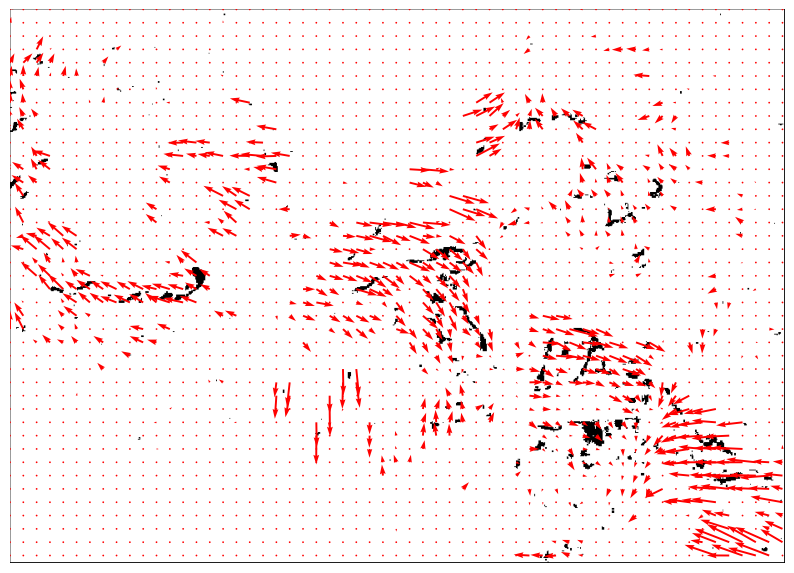

<Figure size 640x480 with 0 Axes>

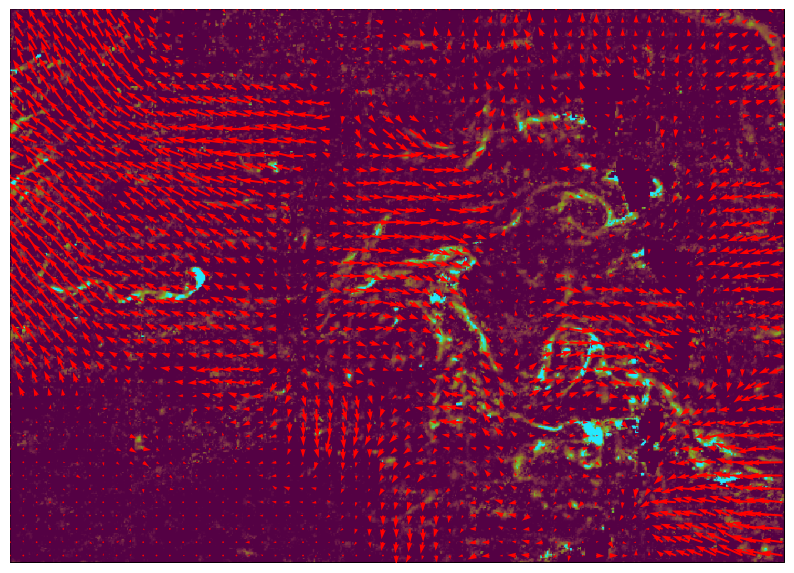

<Figure size 640x480 with 0 Axes>

In [3]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    iterations=4
    poly_n=5
    poly_sigma=1.2
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

Changing this parameter changes the result significantly. We'll leave it at **poly_sigma=1.2** for now.

### flags
operation flags that can be a combination of the following:
- OPTFLOW_USE_INITIAL_FLOW uses the input flow as an initial flow approximation.
- OPTFLOW_FARNEBACK_GAUSSIAN uses the Gaussian filter instead of a box filter of the same size for optical flow estimation; usually, this option gives z more accurate flow than with a box filter, at the cost of lower speed; normally, winsize for a Gaussian window should be set to a larger value to achieve the same level of robustness.

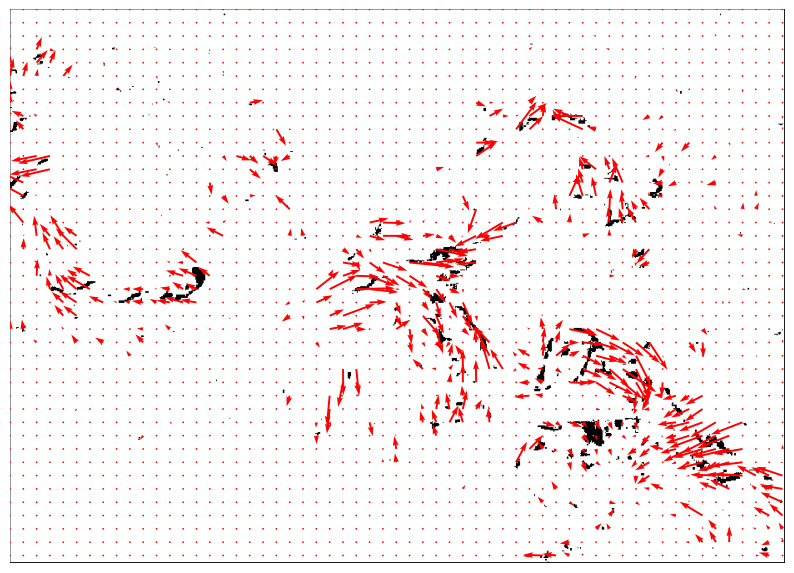

<Figure size 640x480 with 0 Axes>

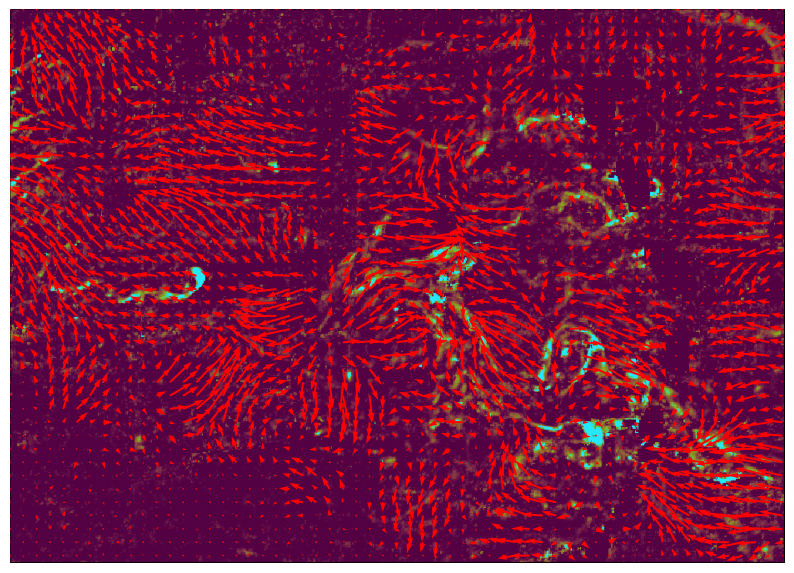

<Figure size 640x480 with 0 Axes>

In [4]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    iterations=4
    poly_n=5
    poly_sigma=1.2
    flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma, flags=flags)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma, flags=flags)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

Using the Gaussian filter seems to make the motion field more "chaotic".

### flow
We can use a flow field obtained from another algorithm (or from this same algorithm) as an initial guess for this algorithm.

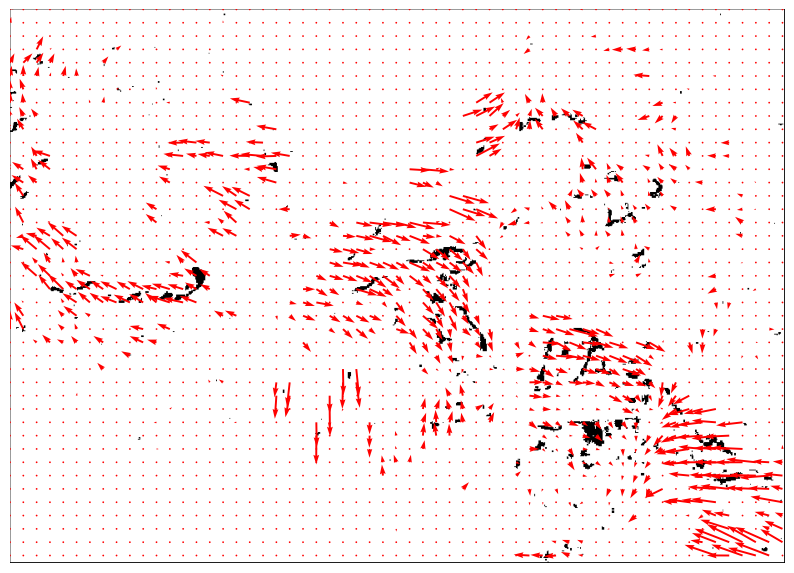

<Figure size 640x480 with 0 Axes>

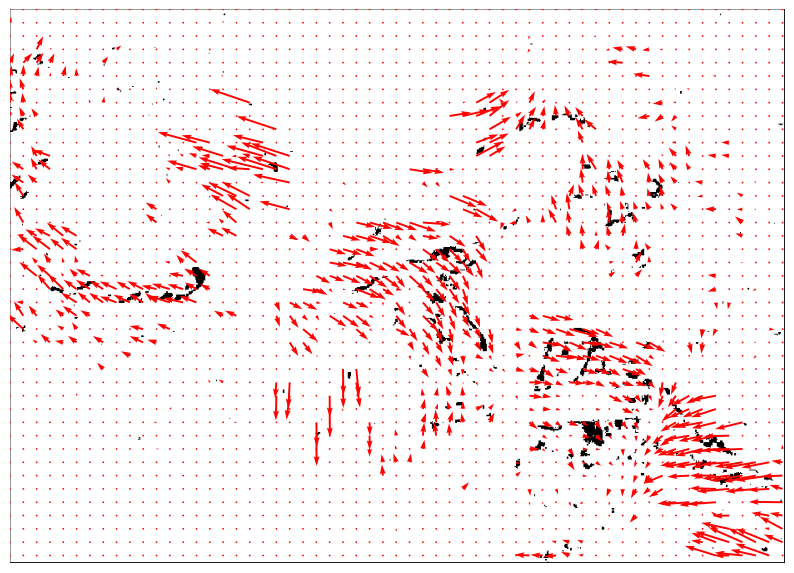

<Figure size 640x480 with 0 Axes>

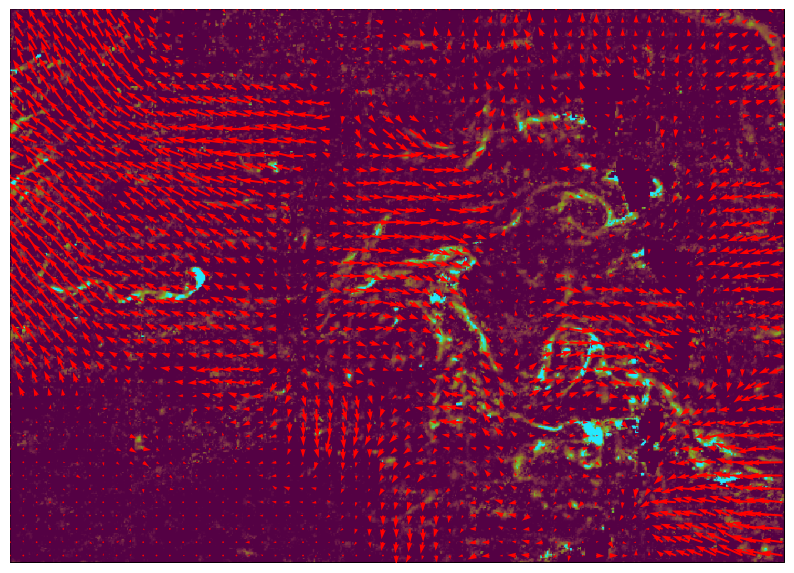

<Figure size 640x480 with 0 Axes>

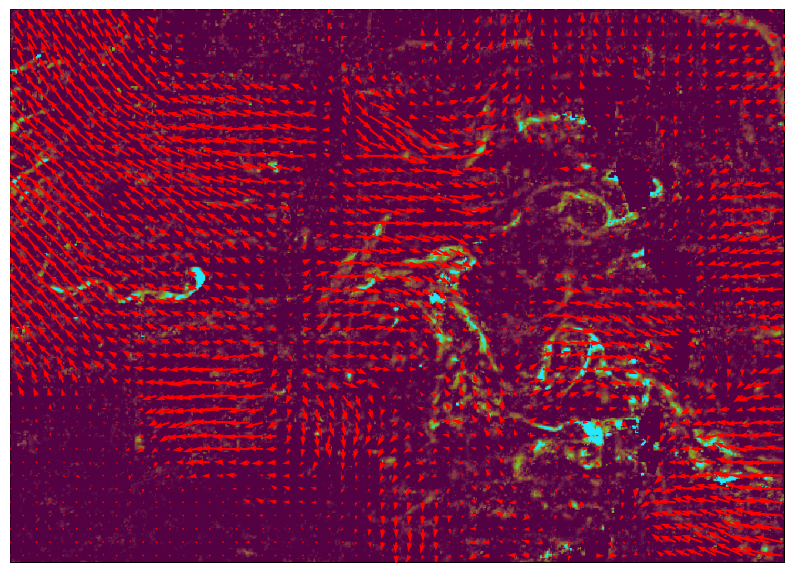

<Figure size 640x480 with 0 Axes>

In [5]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    iterations=4
    poly_n=5
    poly_sigma=1.2
    flags=cv2.OPTFLOW_USE_INITIAL_FLOW
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow1 = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow1, prev_img, step=16, scale=1.25)

    # Binarized with Initial Flow
    flow2 = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma, flow=flow1, flags=flags)
    plot_flow_vectors(flow2, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow3 = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow3, prev_img, step=16, scale=1.25)

    # Viridis with Initial Flow
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow4 = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma, flow=flow3, flags=flags)
    plot_flow_vectors(flow4, prev_img, step=16, scale=1.25)

Using the resultant flow as an initial estimate to the same algorithm seems to exaggerate the motion of the algae (comparable to having a higher number of iterations).

## Conclusion
It is hard, if not impossible, to find the ideal parameters for every image we have in our database. For some successive images, the motion would be too large for the parameters and for others it will be too small. So the purpose of this notebook was not to find the ideal parameters, but rather to understand the influence of each of these parameters on the result.

Retained parameters are:   
- pyr_scale=0.1
- levels=3
- winsize=15
- iterations=4
- poly_n=5
- poly_sigma=1.2

## Other Dates

### 23/07 - 24/07

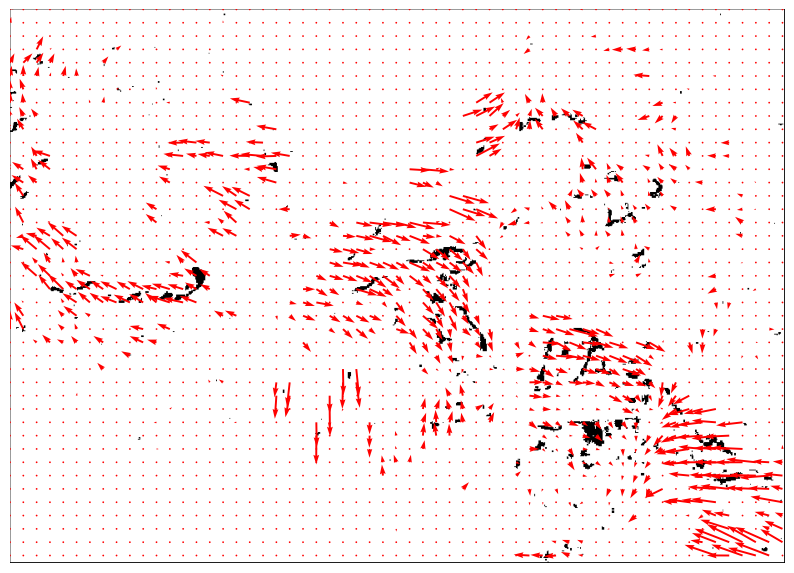

<Figure size 640x480 with 0 Axes>

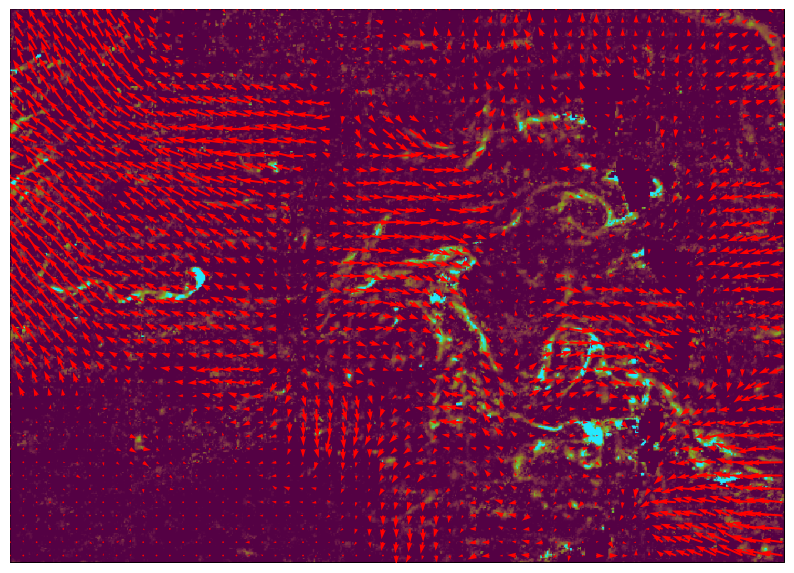

<Figure size 640x480 with 0 Axes>

In [6]:
if __name__ == '__main__':
    pyr_scale=0.1
    levels=3
    winsize=15
    iterations=4
    poly_n=5
    poly_sigma=1.2
    # Binarized
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

    # Viridis
    prev_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

### 05/18 - 05/19

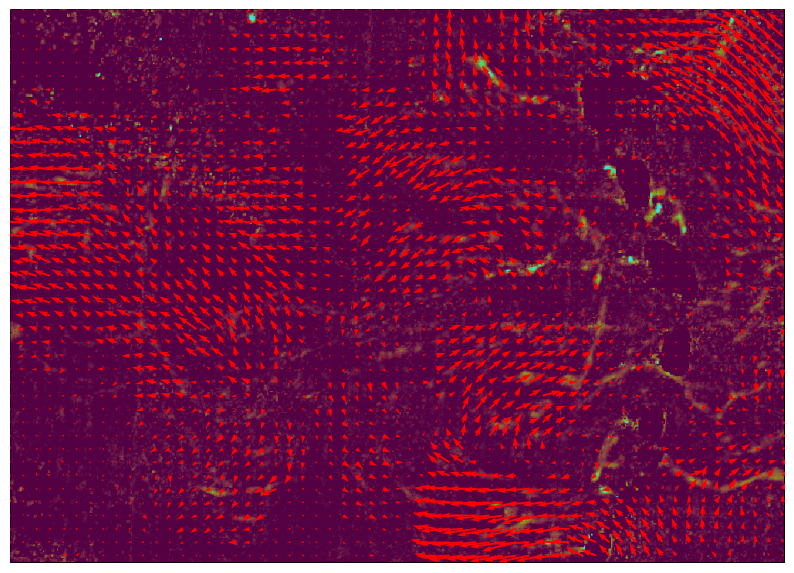

<Figure size 640x480 with 0 Axes>

In [11]:
if __name__ == '__main__':
    # Viridis
    prev_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220518.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220519.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

### 05/21 - 05/22

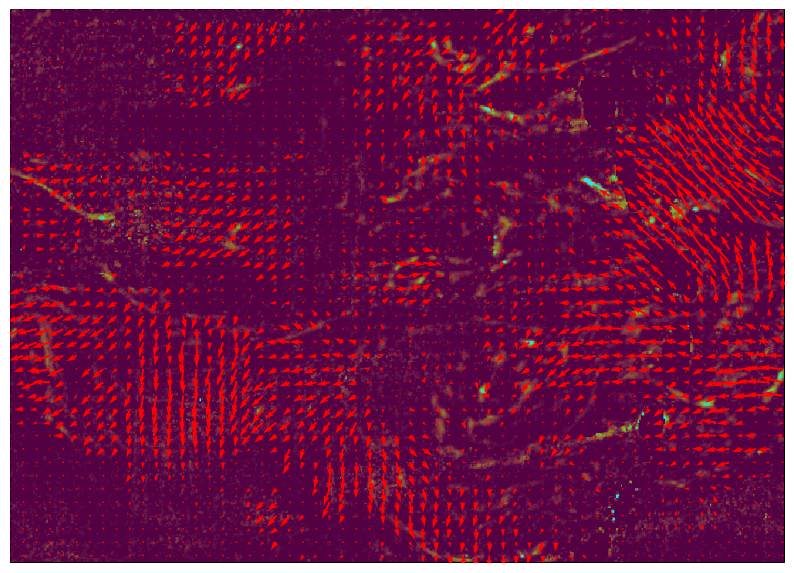

<Figure size 640x480 with 0 Axes>

In [12]:
if __name__ == '__main__':
    # Viridis
    prev_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220521.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220522.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

### 07/03 - 07/04

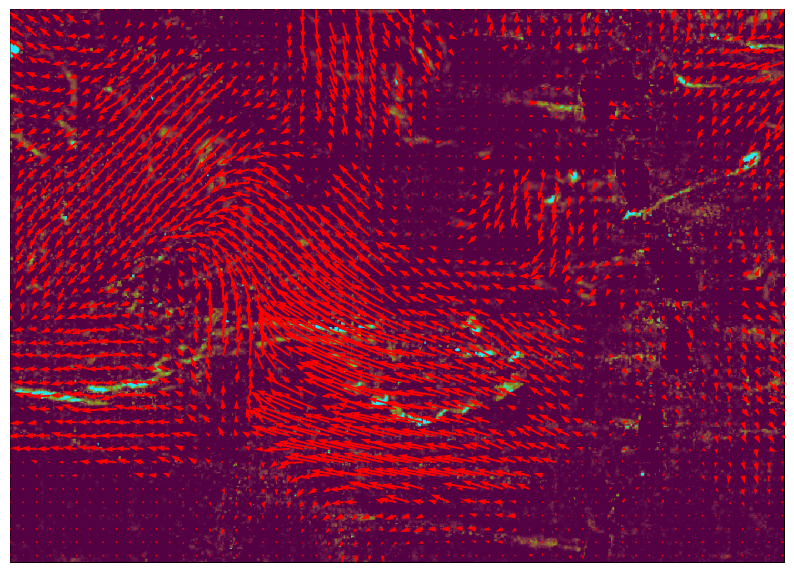

<Figure size 640x480 with 0 Axes>

In [13]:
if __name__ == '__main__':
    # Viridis
    prev_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220703.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220704.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

### 07/13 - 07/14

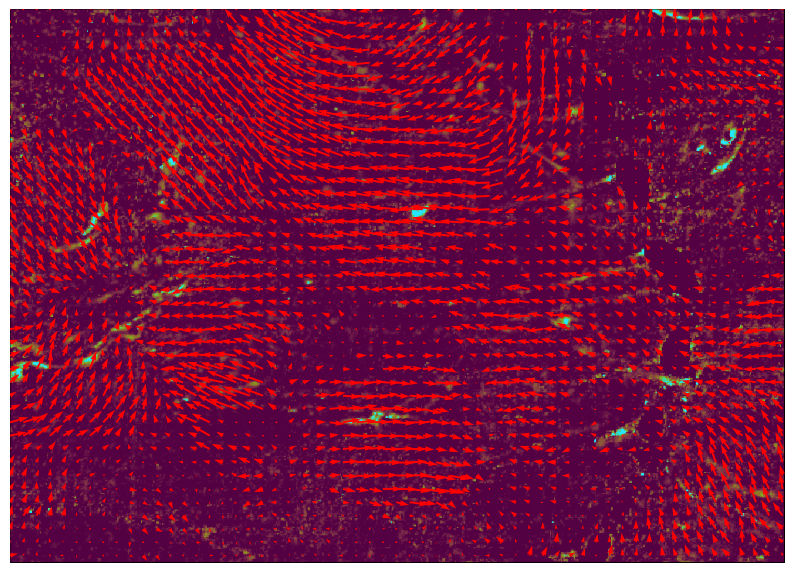

<Figure size 640x480 with 0 Axes>

In [15]:
if __name__ == '__main__':
    # Viridis
    prev_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220713.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/ABI_Averages_Antilles_Processed/Processed_algae_distribution_20220714.png")
    flow = farneback(prev_img, next_img, pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, poly_n=poly_n, poly_sigma=poly_sigma)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)

## Zoom

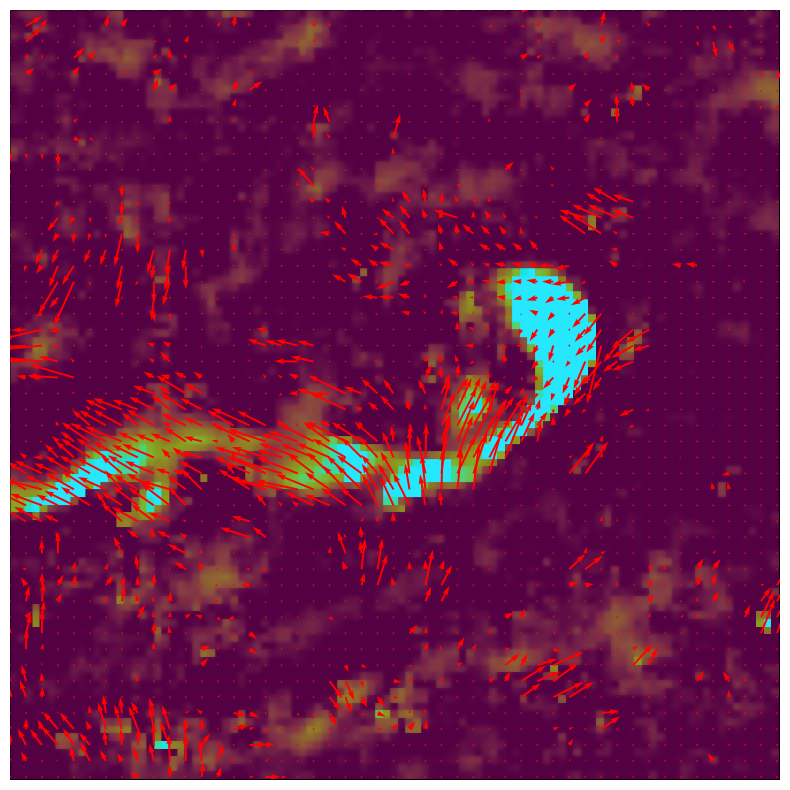

<Figure size 640x480 with 0 Axes>

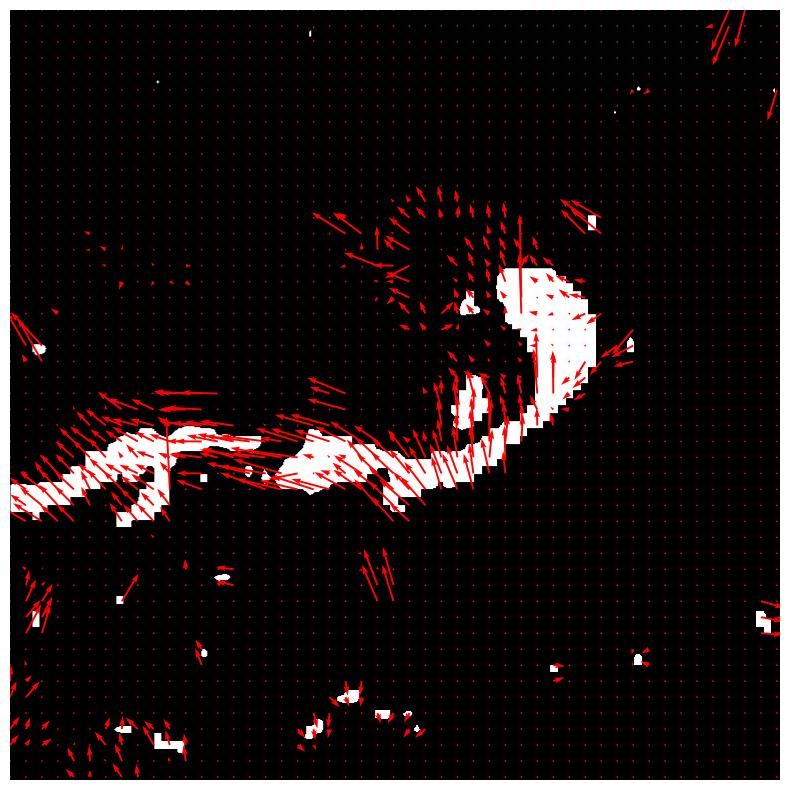

<Figure size 640x480 with 0 Axes>

In [16]:
if __name__ == '__main__':
    # Viridis
    prev_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Processed/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Processed/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=0.1, levels=3, winsize=15, iterations=4, poly_n=5, poly_sigma=1.2)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)
    # Binarized
    prev_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Binarized_Bilateral/Processed_algae_distribution_20220723.png")
    next_img = cv2.imread("/media/yahia/ballena/ABI/Spiral/ABI_Averages_Spiral_Binarized_Bilateral/Processed_algae_distribution_20220724.png")
    flow = farneback(prev_img, next_img, pyr_scale=0.1, levels=3, winsize=15, iterations=4, poly_n=5, poly_sigma=1.2)
    plot_flow_vectors(flow, prev_img, step=16, scale=1.25)